In [4]:
import time
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def timestamp_to_datetime(timestamp):    
    return datetime.fromtimestamp(float(timestamp))

# Download Bitcoin price data set as CSV file

I've used http://api.bitcoincharts.com/v1/csv/ to download the Bitstamp BTCUSD dataset, and imported it as a Pandas DataFrame.
Note that the CSV file used in this example is a reduced version of the original one, to avoid huge amount of unnecessary data.

In [5]:
df_original = pd.read_csv(
    '/Users/mzugnoni/Desktop/bitstampUSD-01-07-2018-medium.csv', 
    names=["Datetime", "Price", "Volume"],
    index_col=0,
    parse_dates=True,
    date_parser=timestamp_to_datetime
)

In [8]:
df_original.head()

,Price,Volume
Datetime,,
2018-02-11 12:03:21,8410.00,0.429749
2018-02-11 12:03:25,8416.55,0.002529
2018-02-11 12:03:26,8410.00,0.541440
2018-02-11 12:03:26,8410.00,0.658560
2018-02-11 12:03:37,8410.00,0.004487


For the purpose of this analysis, we will use only 2018 rows.

In [9]:
df = df_original.loc["2018-01-01":, ["Price"]].copy()

# Calculate candles
Group prices in the DataFrame by regular periods of time to get a candles-like format (open, close, low, high columns). For that we use the `.ohlc()` groupping function.

In [10]:
df = df["Price"].resample('D').ohlc()

In [11]:
df.head()

,open,high,low,close
Datetime,,,,
2018-02-11,8410.00,8542.87,8026.00,8539.41
2018-02-12,8538.03,8995.00,8356.40,8725.49
2018-02-13,8725.22,8782.00,8360.13,8671.76
2018-02-14,8676.88,9682.73,8642.08,9640.77
2018-02-15,9640.77,10300.00,9499.01,10212.07


# Calculate Bollinger bands
To demostrate the strategy we will use a 30 periods rolling mean window, and 1.5 standard deviations for each of the bands. This might not be the optimal configuration for this data set, but we will talk more about optimizing these two arguments later.

In [12]:
# set number of days and standard deviations to use for rolling 
# lookback period for Bollinger band calculation
window = 30
no_of_std = 1.5

# calculate rolling mean and standard deviation
rolling_mean = df['close'].rolling(window).mean()
rolling_std = df['close'].rolling(window).std()

# create two new DataFrame columns to hold values of upper and lower Bollinger bands
df['Rolling Mean'] = rolling_mean
df['Bollinger High'] = rolling_mean + (rolling_std * no_of_std)
df['Bollinger Low'] = rolling_mean - (rolling_std * no_of_std)

In [13]:
df.tail()

,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low
Datetime,,,,,,,
2018-06-27,6074.21,6181.11,5985.00,6111.95,6893.841333,7772.343346,6015.339321
2018-06-28,6111.95,6136.13,5818.14,5862.59,6838.563000,7742.251958,5934.874042
2018-06-29,5860.56,6510.00,5774.72,6394.77,6806.991333,7706.967198,5907.015469
2018-06-30,6396.47,6449.78,6305.61,6343.49,6768.675667,7655.636287,5881.715046
2018-07-01,6347.43,6397.21,6331.93,6360.22,6731.056667,7600.605905,5861.507428


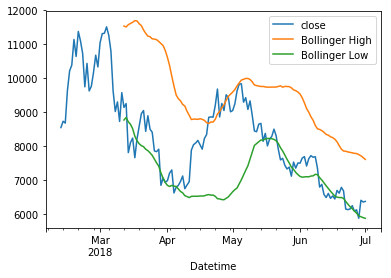

In [14]:
df[['close','Bollinger High','Bollinger Low']].plot()

# Let's work on the strategy
This is a very simple trading strategy. If the rolling mean (blue line) touches the upper band (orange line), we will short BTCUSD. If it touches the lower band (gree line), we will long it. This is far away from being an optimal trading strategy, but for the purpose of this experimient it's enough.

In [15]:
# create a new column in the DataFrame to hold positions information
df['Position'] = None

# fill our position column based on the following rules:
#     * set to short (-1) when the price hits the upper band
#     * set to long (1) when it hits the lower band       
mode = 'open'
for index in range(len(df)):
    if index == 0:
        continue

    row = df.iloc[index]
    prev_row = df.iloc[index - 1]

    # long?
    if mode == 'open' and row['close'] < row['Bollinger Low'] and prev_row['close'] > prev_row['Bollinger Low']:
        df.iloc[index, df.columns.get_loc('Position')] = 1
        mode = 'close'

    # short?
    if mode == 'close' and row['close'] > row['Bollinger High'] and prev_row['close'] < prev_row['Bollinger High']:
        df.iloc[index, df.columns.get_loc('Position')] = -1
        mode = 'open'

Let's check how many operations our strategy found. As we consider to be "out of market" at the beginning of the backtesting, the first operation will alway be a "long". As long as the strategy goes on, we will alternate between "long" and "short", but never perform two consecutive operations of the same type.

In [16]:
df.dropna(subset=['Position'])

,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low,Position
Datetime,,,,,,,,
2018-03-14,9248.14,9345.94,7753.32,7800.01,10141.640667,11575.530069,8707.751264,1
2018-04-20,8332.98,8934.00,8216.90,8841.97,7611.111000,8660.044168,6562.177832,-1
2018-05-15,8664.03,8865.00,8100.01,8133.43,8960.849667,9752.564291,8169.135042,1


# Visualizing positions
We found that the current configuration of the strategy found 3 operations in the time window we specified (since beginning of 2018).
It would be useful to visualize this information in a plot, to see when we short and when we long BTCUSD based on the pre defined rules.

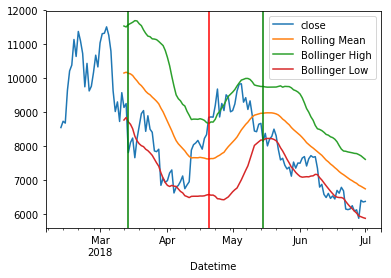

In [18]:
df[['close', 'Rolling Mean', 'Bollinger High','Bollinger Low']].plot()

for index, pos in df.dropna(subset=['Position'])['Position'].iteritems():
    plt.axvline(index, color='green' if pos == 1 else 'red')

The background plot is the same I displayed before, including the rolling mean of the "close" price, and both high and low Bollinger bands.
Each green vertical line represent a "long" position, and each red line a "short" one.
As we see, we initially set a long position and the price went up (that's good), then we shorted it and the price when down again (this looks great!), but finally we set a long position and the price started dropping. This might cause some losses in our returns. We will get into more details about the strategy returns later.

# What's the return of the strategy?
Based on the operations we opened, we can calculate how good or bad the strategy is by analyzing how the market price changed and see if it was favorable for us depending on the position we took.

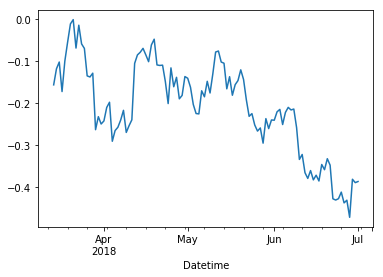

In [19]:
# forward fill our Position column to replace "None" values with the correct buy/sell 
# operations to represent the "holding" of our position forward through time
df['Position'].fillna(method='ffill', inplace=True)

# calculate the daily market return and multiply that by the position to determine strategy returns
df['Market Return'] = df['close'].pct_change()
df['Strategy Return'] = df['Market Return'] * df['Position']

# plot the strategy returns
df['Strategy Return'].cumsum().plot()

The strategu returns definitely doesn't look good. We "lost" around 38% of the investment after the backtesting simulation. That doesn't mean the strategy is not valid. It only means the paramaeters we used for the roalling window and number of standard deviations are not good enough.

# Finding a better configuration
As we explained before, we need to find a better set of values for amount of days in the rolling window, and number of standard deviations, that gives us a better return after the simulation.
How can we do that? My proposal is to define a space of the possible values we want to use, and take some samples from there. It wouldn't be convenient to avaluate all possible convinations, because that turns to be almost infinite. Choosing some random values distributed in the space should be enough.

I will start by refactoring the previous code, into a reusable class. The goal is to build a brute force simulation with random values taken from the acceptable space.

In [25]:
class BollingerBandsSimulator:

    def __init__(self, df_original, from_date, period, window, no_of_std, figsize=None):
        self.df = df_original
        self.from_date = from_date
        self.period = period
        self.window = window
        self.no_of_std = no_of_std
        self.figsize = figsize
    
    def _build_candles_dataframe(self):
        self.df = self.df.loc[self.from_date:, ["Price"]].copy()
        self.df = self.df["Price"].resample(self.period).ohlc()
                
    def _build_bollinger_bands(self):
        rolling_mean = self.df['close'].rolling(self.window).mean()
        rolling_std = self.df['close'].rolling(self.window).std()

        self.df['Rolling Mean'] = rolling_mean
        self.df['Bollinger High'] = rolling_mean + (rolling_std * self.no_of_std)
        self.df['Bollinger Low'] = rolling_mean - (rolling_std * self.no_of_std)

    def _calculate_positions(self):
        self.df['Position'] = None

        mode = 'open'
        for index in range(len(self.df)):
            if index == 0:
                continue

            row = self.df.iloc[index]
            prev_row = self.df.iloc[index - 1]

            # open?
            if mode == 'open' and row['close'] < row['Bollinger Low'] and prev_row['close'] > prev_row['Bollinger Low']:
                self.df.iloc[index, self.df.columns.get_loc('Position')] = 1
                mode = 'close'

            # close?
            if mode == 'close' and row['close'] > row['Bollinger High'] and prev_row['close'] < prev_row['Bollinger High']:
                self.df.iloc[index, self.df.columns.get_loc('Position')] = -1
                mode = 'open'        
        
    def _calculate_returns(self):
        self.df['Position'].fillna(method='ffill', inplace=True)
        self.df['Market Return'] = self.df['close'].pct_change()
        self.df['Strategy Return'] = self.df['Market Return'] * self.df['Position']

    def _plot_returns(self):
        self.df['Strategy Return'].cumsum().plot(figsize=self.figsize)

    def simulate(self):
        self._build_candles_dataframe()
        self._build_bollinger_bands()
        self._calculate_positions()
        self._calculate_returns()
        self._plot_returns()

        return (
            self.period, 
            self.window, 
            self.no_of_std, 
            self.df['Strategy Return'].sum()
        )

('24H', 30, 1.5, -0.38708190652921637)

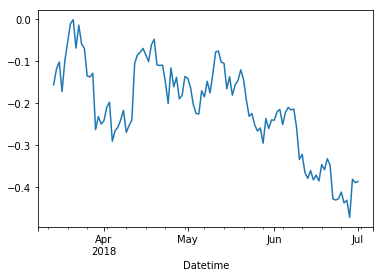

In [27]:
simulator = BollingerBandsSimulator(
    df_original, 
    from_date="2018-01-01", 
    period="24H", 
    window=30, 
    no_of_std=1.5
)
simulator.simulate()

# Brute force some configurations
As explained before, we will take some random values for the strategy configuration and run the backtesting with them. After running them all, we can compare them to see what's the best option for the current data set. Of course the best configuration will be the one giving better returns.

In [21]:
# generate a linear space of value values for each parameter in the configuration
# a take some random samples from them.
# for example the first one creates a vector of 5 evenly spaced integer values ranging from 10 to 100
windows = np.linspace(10, 100, 5, dtype=int)
stds = np.linspace(1, 3, 5)
periods = np.array([12, 24])

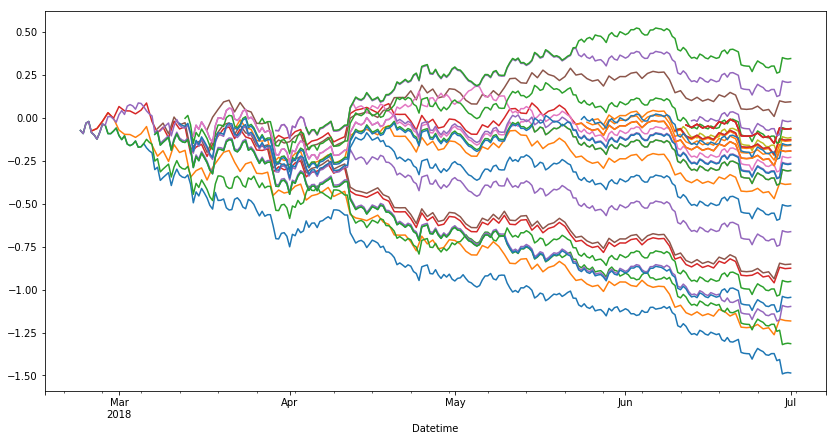

In [32]:
# iterate through them, running the strategy function each time and collecting returns
# (this might take some time)
result_df = pd.DataFrame({
    'period': [], 
    'window': [],
    'no_of_std': [],
    'result': []
})
for window in windows:
    for std in stds:
        for period in periods:
            simulator = BollingerBandsSimulator(
                df_original, 
                from_date="2018-02-11", 
                period="{}H".format(period), 
                window=window, 
                no_of_std=std,
                figsize=(14, 7)
            )
            period, window, no_of_std, result = simulator.simulate()
            result_df = result_df.append({
                'period': period, 
                'window': window, 
                'no_of_std': no_of_std, 
                'result': result
            }, ignore_index=True)

The plot shows us all return curves in a single canvas. We can easily compare all the configurations, and figure out that at least a few of them have positive returns!
Now, the question is: how can we know which of them generated the best returns?
Well, that's why we stored returns in the `result_df` DataFrame. Now we only need to sort it, and print the best ones.

In [30]:
result_df.sort_values(by=['result'], ascending=False)[:5]

,period,window,no_of_std,result
42,12H,100.0,1.5,0.343511
34,12H,77.0,2.0,0.207383
15,24H,32.0,2.0,0.091948
49,24H,100.0,3.0,0.000000
27,24H,55.0,2.5,0.000000


If our analysis was correct, using `12H` candles, 100 periods rolling window and 1.5 amount of standard deviations should  give us the best returns.

Let's test it for one last time.

('12H', 100, 1.5, 0.3435107043395028)

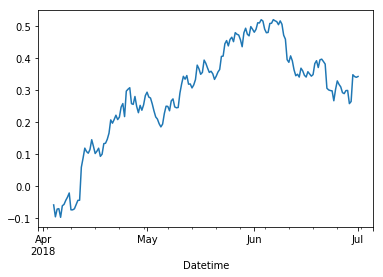

In [31]:
simulator = BollingerBandsSimulator(
    df_original, 
    from_date="2018-01-01", 
    period="12H", 
    window=100, 
    no_of_std=1.5
)
simulator.simulate()

Indeed, that was the best configuration. Around 35% return over the initial capital.

# Final conclusions
Despite being a cool experiment, don't use this as finantial advice. Returns in this simulations are based on past prices and events, and by no mean can guarantee that the same results will stay in the future under the same configurations.